# Video processing

We will implement the first steps of video processing for a single recording session.

We need to do apply a mask and crop the original video for the best and fastest position tracking using deeplabcut.

Here are the steps done below.

With the `arena_top.avi` file

* Detect the bridge and arena in arena_top.avi
* Crop the arena_top.avi to 480x480

With the cropped video

* Detect arena in cropped video
* Detect bridge in cropped video
* Detect the mouse and lever in cropped video


In [1]:
import os.path
import importlib
import autopipy

## Create a session object

The next 3 variables needs to be set according to the session you want to analyze and the folder containing your deeplabcut models.

In [2]:
sessionName="mn4656-04102019-1436"
sessionPath="/adata/electro/mn4656/"+sessionName
modelDir="/adata/models"

In [4]:
from autopipy.session import session
#from session import session
s = session(path=sessionPath,name=sessionName)
print(s)

<class 'autopipy.session.session'>
name = mn4656-04102019-1436
path = /adata/electro/mn4656/mn4656-04102019-1436
fileBase = /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436
arenaTopVideo = True
homeBaseVideo = True
requiredFileExts = ['log', 'protocol', 'arena_top.avi', 'arena_top.log', 'home_base.avi', 'home_base.log']
dirOk = True
arenaTopCropped = True
fileNames = {'log': '/adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.log', 'protocol': '/adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.protocol', 'arena_top.avi': '/adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.avi', 'arena_top.cropped.avi': '/adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.avi'}


## Detect the arena

We start with a 640x480 pixels video of the arena. 

We will detect the arena in it using the first 100 frames.

In [6]:
from autopipy.cvObjectDetectors import arenaDetector

In [7]:
videoFile = s.fileNames["arena_top.avi"] #Nice trick to get file names using a dict
arenaImageFile=s.path+"/arenaDetection.png"
arenaD = arenaDetector()
aCoord = arenaD.detectArenaCoordinates(pathVideoFile=videoFile, minRadius=180, 
                              maxRadius=220, numFrames=100, blur=11, circle='min')
arenaD.labelImage(pathVideoFile=videoFile,outputImageFile=arenaImageFile)

labelImage: /adata/electro/mn4656/mn4656-04102019-1436/arenaDetection.png


## Detect the bridge

Only use the first 100 frames as the bridge is not moving

In [8]:
from autopipy.dlcObjectDetectors import bridgeDetector

In [9]:
configFile = modelDir+"/detectBridgeDLC/arena_top-Allen-2020-08-20/config.yaml"
bridgeImageFile = s.path+"/bridgeDetection.png"
bridgeD = bridgeDetector(pathConfigFile=configFile)
bCoord = bridgeD.detectBridgeCoordinates(pathVideoFile=videoFile,numFrames=100, skip=30)
bridgeD.labelImage(pathVideoFile=videoFile,outputImageFile=bridgeImageFile)

/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-1030000 for model /adata/models/detectBridgeDLC/arena_top-Allen-2020-08-20/dlc-models/iteration-0/arena_topAug20-trainset95shuffle1
Initializing ResNet


KeyboardInterrupt: 

## Mask and crop the video to 480 x 480

We now need to create a mask to set the pixels outside of the arena to 0. 
This will prevent detecting the mouse away from the arena (false positive).

The 480 x  480 pixels is used to detect the mouse and the lever during the task.

In [17]:
from autopipy.video_utilities import maskCropVideoToBridgeArena

In [18]:
videoFile=s.fileNames["arena_top.avi"]
croppedVideoFile = os.path.splitext(videoFile)[0]+".cropped.avi"
maskCropVideoToBridgeArena(pathVideoFile=videoFile, pathOutputFile=croppedVideoFile, 
                           arenaCoordinates=aCoord, bridgeCoordinates = bCoord)

Cropping and masking 108552 frames in /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.avi
Output file /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.avi
108550 of 108552 frames
Exiting. Video saved as /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.avi


## Detect the mouse and lever in the cropped video

This is the position data used for most of the analysis.

In [19]:
from autopipy.dlcObjectDetectors import mouseLeverDetector

In [20]:
configFile=modelDir+"/arena_top-Allen-2019-10-30/config.yaml"
croppedVideoFile = os.path.splitext(videoFile)[0]+".cropped.avi"
mouseLeverD = mouseLeverDetector(pathConfigFile=configFile)

Do the inference with the model. It will be faster if your version of DLC is using a GPU.

In [21]:
mouseLeverD.inferenceVideo(pathVideoFile=croppedVideoFile,overwrite=True)

Removing previous inference data: /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_1030000.h5
Running dlc.analyze_video on /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.avi
Using snapshot-1030000 for model /adata/models/arena_top-Allen-2019-10-30/dlc-models/iteration-0/arena_topOct30-trainset95shuffle1
Initializing ResNet


  0%|          | 0/108552 [00:00<?, ?it/s]

Starting to analyze %  /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.avi
/adata/electro/mn4656/mn4656-04102019-1436  already exists!
Loading  /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.avi
Duration of video [s]:  3618.4 , recorded with  30.0 fps!
Overall # of frames:  108552  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


109585it [19:28, 93.76it/s]                            

Detected frames:  108552
Saving results in /adata/electro/mn4656/mn4656-04102019-1436...


The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Saving position data to /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.croppedDLC_resnet_50_arena_topOct30shuffle1_1030000.csv


In [22]:
from autopipy.dlcObjectDetectors import mouseLeverDetector

In [23]:
labeledVideoFile = os.path.splitext(croppedVideoFile)[0]+".labeled.avi"
mouseLeverD.labelVideoMouseLever(pathVideoFile=croppedVideoFile,pathOutputFile=labeledVideoFile)

Saving labeled video in /adata/electro/mn4656/mn4656-04102019-1436/mn4656-04102019-1436.arena_top.cropped.labeled.avi
108550 of 108552 frames

## Detect the arena and bridge in the cropped video

Now we need to redo the detection of the arena and the bridge on the cropped video. 
This will be used for the subsequent analysis.

In [24]:
arenaImageFile=s.path+"/arenaDetectionCropped.png"
arenaD = arenaDetector()
aCoord = arenaD.detectArenaCoordinates(pathVideoFile=croppedVideoFile, minRadius=180, 
                              maxRadius=220, numFrames=100, blur=11, circle='min')
arenaD.labelImage(pathVideoFile=croppedVideoFile,outputImageFile=arenaImageFile)

labelImage: /adata/electro/mn4656/mn4656-04102019-1436/arenaDetectionCropped.png


In [25]:
configFile = modelDir+"/bridgeDetection_480_480-Allen-2021-01-23/config.yaml"
bridgeImageFile = s.path+"/bridgeDetectionCropped.png"
bridgeD = bridgeDetector(pathConfigFile=configFile)
bCoord = bridgeD.detectBridgeCoordinates(pathVideoFile=croppedVideoFile,numFrames=100, skip=30)
bridgeD.labelImage(pathVideoFile=videoFile,outputImageFile=bridgeImageFile)

/tmp/tmpVid.avi created for bridge detection
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-420000 for model /adata/models/bridgeDetection_480_480-Allen-2021-01-23/dlc-models/iteration-0/bridgeDetection_480_480Jan23-trainset90shuffle1
Initializing ResNet


  0%|          | 0/100 [00:00<?, ?it/s]

Starting to analyze %  /tmp/tmpVid.avi
/tmp  already exists!
Loading  /tmp/tmpVid.avi
Duration of video [s]:  3.33 , recorded with  30.0 fps!
Overall # of frames:  100  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


110it [00:01, 62.26it/s]                        


Detected frames:  100
Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Saving position data to /tmp/tmpVidDLC_resnet_50_bridgeDetection_480_480Jan23shuffle1_420000.csv
labelImage: /adata/electro/mn4656/mn4656-04102019-1436/bridgeDetectionCropped.png


## Generate a figure to make sure all the video processing steps were successful.

In [31]:
importlib.reload(autopipy.video_utilities)
from autopipy.video_utilities import arenaBridgeDetectionImage

In [32]:
outputImageFile=s.path+"/arenaBridgeDetectionCropped.png"
arenaBridgeDetectionImage(pathVideoFile=croppedVideoFile,
                          outputImageFile=outputImageFile,
                          arenaCoordinates = aCoord,
                          bridgeCoordinates = bCoord)

labelImage: /adata/electro/mn4656/mn4656-04102019-1436/arenaBridgeDetectionCropped.png


Show the image to make sure the video processing and object detection went as planned

Populating the interactive namespace from numpy and matplotlib


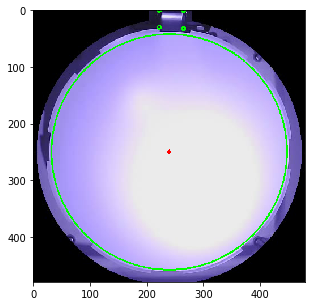

In [33]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [6, 5]
img = mpimg.imread(outputImageFile)
imgplot = plt.imshow(img)
plt.show()